In [2]:
pip install scikit-learn-extra


  Using cached scikit-learn-extra-0.3.0.tar.gz (818 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build scikit-learn-extra
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [74 lines of output]
  C:\Users\DELL\AppData\Local\Temp\pip-build-env-mly5x8gp\overlay\Lib\site-packages\setuptools\dist.py:599: SetuptoolsDeprecationWarning: Invalid dash-separated key 'description-file' in 'metadata' (setup.cfg), please use the underscore name 'description_file' instead.
  !!
  
          ********************************************************************************
          Usage of dash-separated 'description-file' will not be supported in future
          versions. Please use the underscore name 'description_file' instead.
          (Affected: scikit-learn-extra).
  
          By 2026-Mar-03, you need to update your project and remove deprecated calls
          or your builds will no longer be supported.
  
          See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
          ********************************************************************************
  
  !!


Feature names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Target names: ['class_0' 'class_1' 'class_2']
Data shape: (178, 13)
First few rows of data:
    alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28         

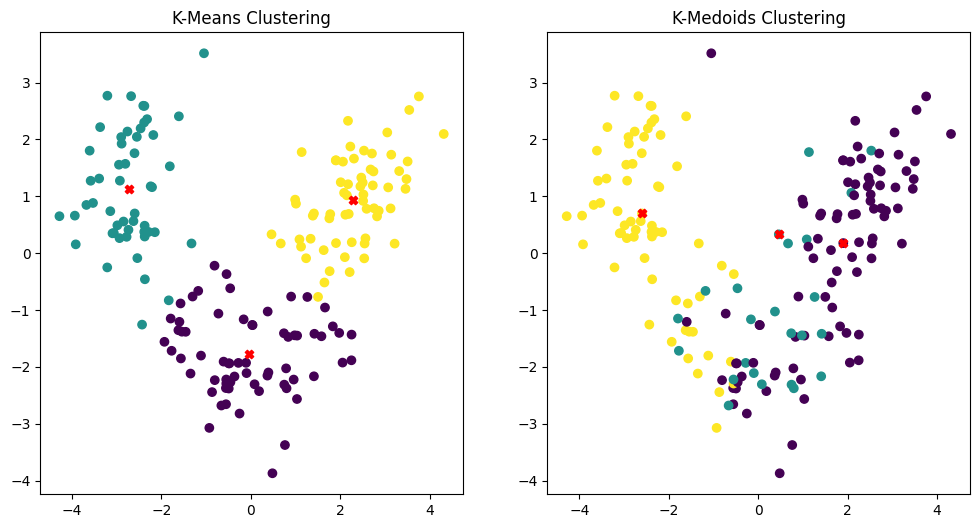

In [5]:
# Step 1: Load and Prepare the Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances

# Load the Wine dataset
wine = load_wine()
data = pd.DataFrame(wine.data, columns=wine.feature_names)
target = wine.target

# Basic exploration
print("Feature names:", wine.feature_names)
print("Target names:", wine.target_names)
print("Data shape:", data.shape)
print("First few rows of data:\n", data.head())

# Standardize the dataset using Z-score normalization
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Step 2: Implement K-Means Clustering
from sklearn.cluster import KMeans

# Implementing K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_scaled)

# Cluster labels
kmeans_labels = kmeans.labels_

# Performance metrics for K-Means
silhouette_kmeans = silhouette_score(data_scaled, kmeans_labels)
ari_kmeans = adjusted_rand_score(target, kmeans_labels)

print("K-Means Silhouette Score:", silhouette_kmeans)
print("K-Means ARI:", ari_kmeans)

# Step 3: Custom Implementation of K-Medoids Clustering
# Custom function to compute the medoid
def compute_medoids(data, labels, k):
    medoids = []
    for i in range(k):
        cluster_points = data[labels == i]
        # Compute distance matrix for the cluster points
        dist_matrix = pairwise_distances(cluster_points)
        # Sum the distances for each point, then choose the one with the minimum sum
        total_distances = np.sum(dist_matrix, axis=1)
        medoid_index = np.argmin(total_distances)
        medoids.append(cluster_points[medoid_index])
    return np.array(medoids)

# Custom K-Medoids clustering algorithm
def kmedoids_custom(data, k, max_iter=100):
    # Randomly initialize the medoids
    np.random.seed(42)
    medoids_indices = np.random.choice(range(data.shape[0]), k, replace=False)
    medoids = data[medoids_indices]
    prev_medoids = np.zeros_like(medoids)
    labels = np.zeros(data.shape[0])

    for _ in range(max_iter):
        # Step 1: Assign each point to the nearest medoid
        dist_matrix = pairwise_distances(data, medoids)
        labels = np.argmin(dist_matrix, axis=1)

        # Step 2: Recompute the medoids
        medoids = compute_medoids(data, labels, k)

        # If the medoids didn't change, convergence is achieved
        if np.all(medoids == prev_medoids):
            break

        prev_medoids = np.copy(medoids)

    return labels, medoids

# Step 3: Implement K-Medoids Clustering using custom function
k = 3
labels_kmedoids, medoids_kmedoids = kmedoids_custom(data_scaled, k)

# Performance metrics for K-Medoids
silhouette_kmedoids = silhouette_score(data_scaled, labels_kmedoids)
ari_kmedoids = adjusted_rand_score(target, labels_kmedoids)

print("K-Medoids Silhouette Score:", silhouette_kmedoids)
print("K-Medoids ARI:", ari_kmedoids)

# Step 4: Visualize and Compare Results
# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Scatter plot for K-Means
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.title('K-Means Clustering')
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', color='red')

# Scatter plot for K-Medoids
plt.subplot(1, 2, 2)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels_kmedoids, cmap='viridis', marker='o')
plt.title('K-Medoids Clustering')
medoids = pca.transform(medoids_kmedoids)
plt.scatter(medoids[:, 0], medoids[:, 1], marker='X', color='red')

plt.show()